In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducible results
torch.manual_seed(42)
np.random.seed(42)

## Dataset Loading
### Column explanations
- Open: The price at which Bitcoin started trading when the market opened
- High: The highest price reached during the trading day
- Low: The lowest price reached during the trading day
- Close: The price at which Bitcoin ended trading when the market closed
- Volume: The total amount of Bitcoin traded during the day (in USD)


In [20]:
df = pd.read_csv('BTC-USD.csv')

if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
    
df['Date'] = pd.to_datetime(df['Date'])    
df.set_index('Date', inplace=True)

print(f"Data loaded: {df.shape[0]} days of Bitcoin price data")
print("First few rows of the dataset:")
print(df.head())

Data loaded: 3222 days of Bitcoin price data
First few rows of the dataset:
                  Open        High         Low       Close    Volume
Date                                                                
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100


## Exploratory Data Analysis (EDA)

### Price Movement Visualization Analysis

**Historical Price Trends:**
- **2014-2016**: Gradual accumulation phase with prices rising from hundreds to ~$1,000
- **2017 Bubble**: Explosive growth to nearly $20,000 in December, followed by sharp correction to $5,000
- **2019-2020**: Steady recovery interrupted by COVID-19 crash (March 2020 drop below $5,000)
- **2021 Bull Market**: Major rally from $10,000 to peak of $69,000 (November 2021)
- **2022-2023 (available on dataset)**: Bear market correction bottoming near $16,000, currently consolidating around $30,000

**Volume Patterns:**
- Volume spikes consistently occur during extreme price movements (both up and down)
- Highest volume periods: Late 2017 bubble, March 2020 crash, and 2021 bull run peaks
- Volume recedes during consolidation periods, indicating reduced market participation

### Correlation Analysis Results
- **Intraday Price Coherence**: High, Low, and Close returns show strong correlations (0.48-0.59)
- **Overnight Disconnect**: Open vs. Close returns are essentially uncorrelated (-0.01), indicating overnight factors significantly impact next-day opens
- **Volume-Price Dynamics**: 
  - Positive correlation with highs (0.32) - upward moves drive trading activity
  - Negative correlation with lows (-0.26) - sell-offs also generate high volume
  - Minimal correlation with closes (0.04) - closing moves alone don't predict volume

Statistical Summary:
               Open          High           Low         Close        Volume
count   3222.000000   3222.000000   3222.000000   3222.000000  3.222000e+03
mean   13633.555524  13966.498897  13269.790975  13641.491658  1.657062e+10
std    16016.593310  16417.423832  15559.562019  16014.439000  1.950701e+10
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06
25%      757.838730    772.024277    745.732499    759.970260  1.300485e+08
50%     7664.044434   7867.845215   7499.634766   7679.053711  1.017502e+10
75%    20210.792481  20660.277832  19811.524414  20238.632813  2.746342e+10
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11


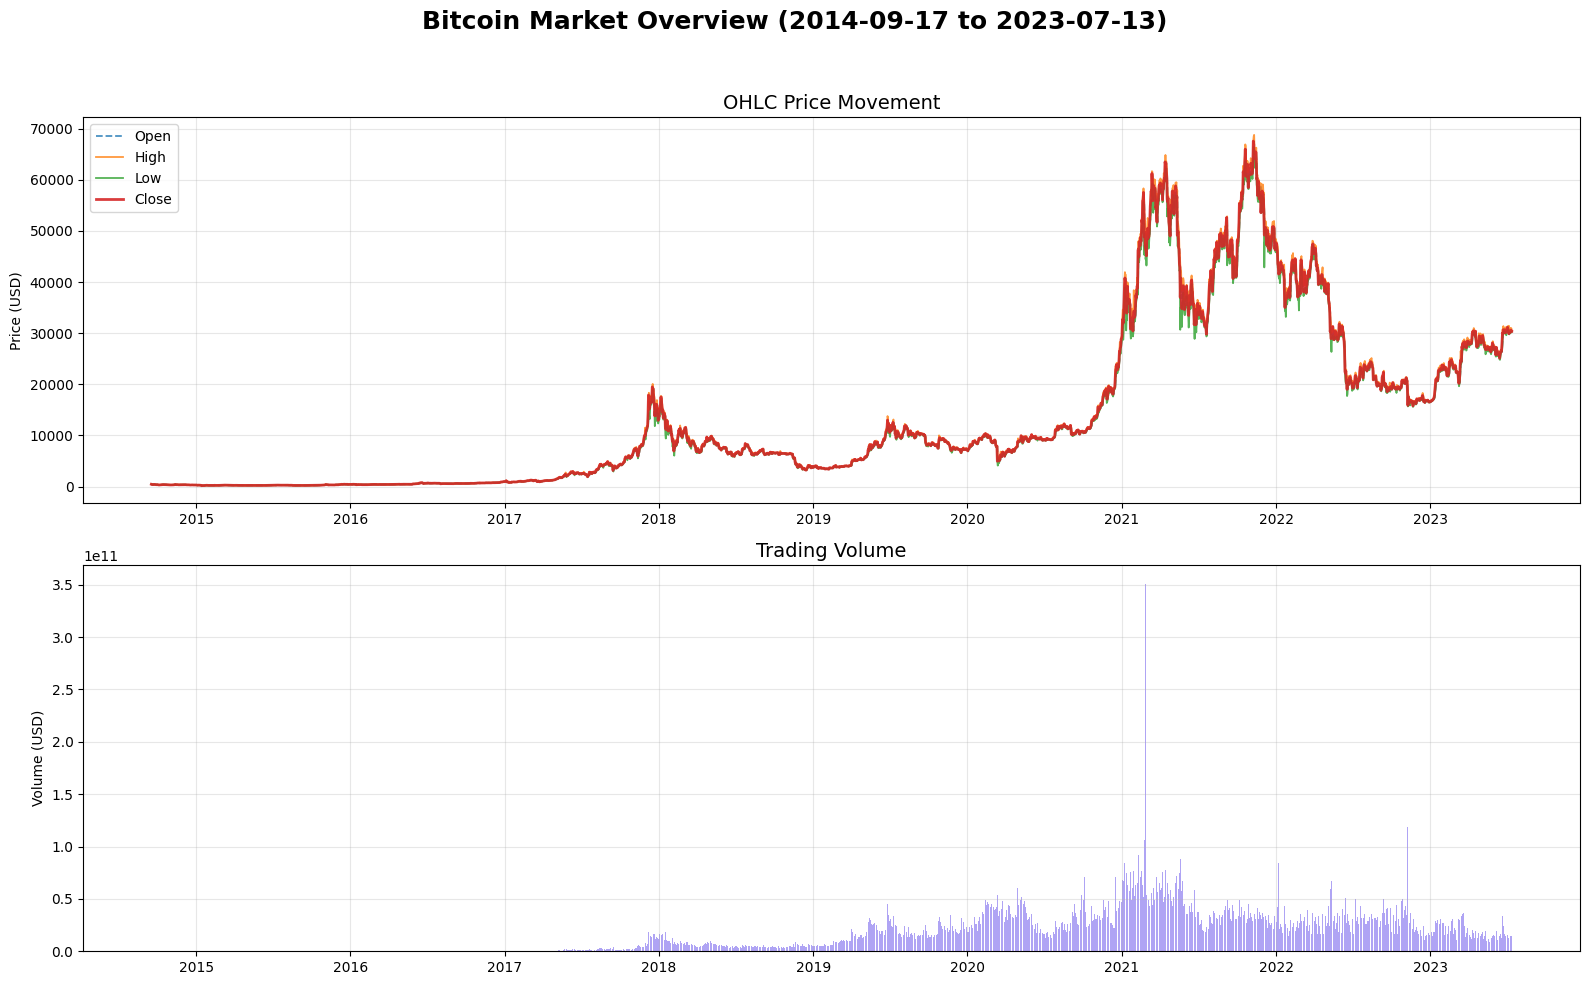

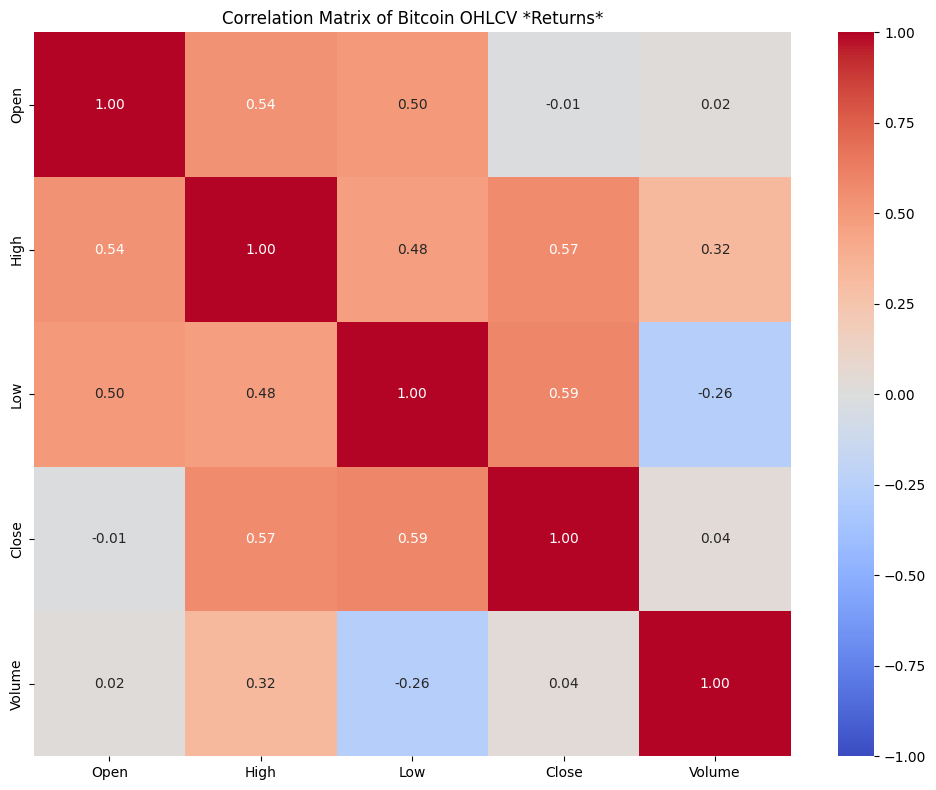

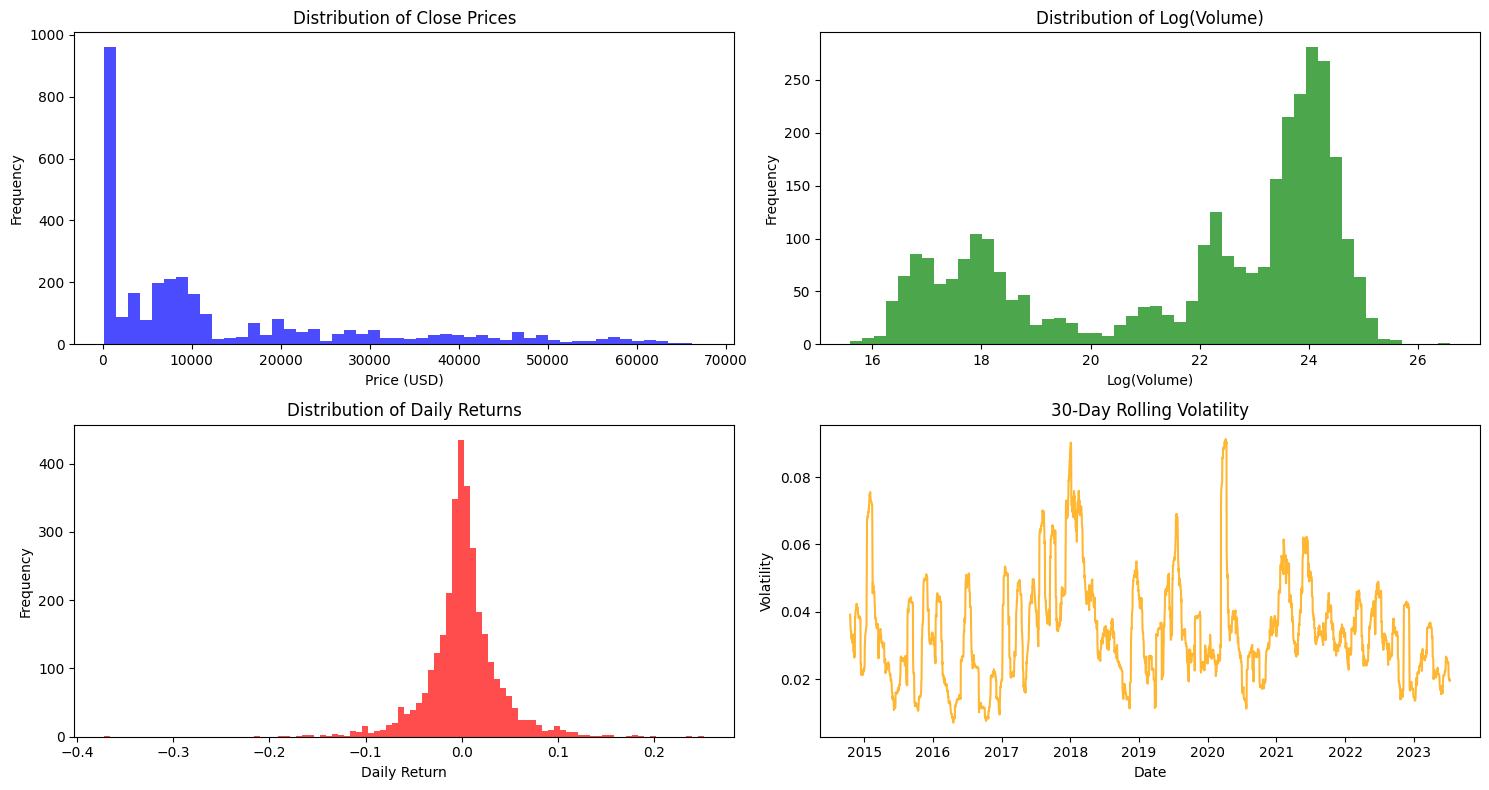

In [21]:
print("Statistical Summary:")
print(df.describe())

# Create figure
plt.figure(figsize=(16, 10))
plt.suptitle('Bitcoin Market Overview (2014-09-17 to 2023-07-13)', fontsize=18, fontweight='bold')

# X-axis locator and formatter for long time range
locator = mdates.YearLocator()  # One tick per year
formatter = mdates.DateFormatter('%Y')

# Plot OHLC
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df.index, df['Open'], label='Open', linestyle='--', linewidth=1.3, alpha=0.8)
ax1.plot(df.index, df['High'], label='High', linestyle='-', linewidth=1.3, alpha=0.8)
ax1.plot(df.index, df['Low'], label='Low', linestyle='-', linewidth=1.3, alpha=0.8)
ax1.plot(df.index, df['Close'], label='Close', linestyle='-', linewidth=2, alpha=0.9)
ax1.set_title('OHLC Price Movement', fontsize=14)
ax1.set_ylabel('Price (USD)')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

# Plot Volume
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.bar(df.index, df['Volume'], color='mediumslateblue', alpha=0.6)
ax2.set_title('Trading Volume', fontsize=14)
ax2.set_ylabel('Volume (USD)')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Check correlations
price_cols = ['Open', 'High', 'Low', 'Close']
returns = df[price_cols].pct_change()
vol_ret = df['Volume'].pct_change()

ret_df = pd.concat([returns, vol_ret.rename('Volume')], axis=1).dropna()

corr_ret = ret_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_ret, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Bitcoin OHLCV *Returns*')
plt.tight_layout()
plt.show()

# Additional EDA - Price distributions
plt.figure(figsize=(15, 8))

# Price distribution
plt.subplot(2, 2, 1)
plt.hist(df['Close'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Close Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')

# Volume distribution (log scale)
plt.subplot(2, 2, 2)
plt.hist(np.log1p(df['Volume']), bins=50, alpha=0.7, color='green')
plt.title('Distribution of Log(Volume)')
plt.xlabel('Log(Volume)')
plt.ylabel('Frequency')

# Daily returns distribution
daily_returns = df['Close'].pct_change().dropna()
plt.subplot(2, 2, 3)
plt.hist(daily_returns, bins=100, alpha=0.7, color='red')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')

# Volatility over time (30-day rolling std of returns)
plt.subplot(2, 2, 4)
volatility = daily_returns.rolling(window=30).std()
plt.plot(volatility.index, volatility, color='orange', alpha=0.8)
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.tight_layout()
plt.show()


## Data Processing


### Explanation of target choice
We've chosen the percentage change in closing price over the next day as our target.
This has several advantages:
1. Percentage changes are scale-invariant, working regardless of whether BTC is $10K or $60K
2. It directly represents potential profit/loss - positive values indicate upward movement
3. It removes long-term trends and focuses on daily movements which are more predictable
4. It naturally normalizes the target variable


### On importance of validation set 
Using both validation and test sets is better because:
- The validation set helps us tune hyperparameters without exposing the model to test data
- The test set gives us an unbiased evaluation of the final model
- This prevents information leakage and provides a more realistic assessment of model performance

In [25]:
# Feature Engineering - Creating our target
df['Target'] = df['Close'].pct_change(periods=1).shift(-1) * 100  # next day's % change

missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)
# Drop NaN values
df.dropna(inplace=True)

# Normalization
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Add target back
df_scaled['Target'] = df['Target']

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length]['Target']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Testing different lookback periods
lookback_periods = [30, 60, 90]
sequences = {}

print("\nCreating sequences with different lookback periods...")
for period in lookback_periods:
    X, y = create_sequences(df_scaled, period)
    sequences[period] = (X, y)
    print(f"- Lookback {period} days: {X.shape[0]} sequences created")

# Choose one period for the next steps (we'll use all for comparison)
lookback = 60 
X, y = sequences[lookback]

# Split data
train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"\nData split:")
print(f"- Training set: {X_train.shape[0]} samples")
print(f"- Validation set: {X_val.shape[0]} samples")
print(f"- Test set: {X_test.shape[0]} samples")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



Missing values in each column:
Open      0
High      0
Low       0
Close     0
Volume    0
Target    1
dtype: int64

Creating sequences with different lookback periods...


- Lookback 30 days: 3190 sequences created
- Lookback 60 days: 3160 sequences created
- Lookback 90 days: 3130 sequences created

Data split:
- Training set: 2212 samples
- Validation set: 316 samples
- Test set: 632 samples


## RNN Model Architecture

In [26]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate through RNN
        out, _ = self.rnn(x, h0)
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through the fully connected layer
        out = self.fc(out)
        
        return out

# Model parameters
input_size = 6  # 5 features: Open, High, Low, Close, Volume | and target?
hidden_size = 64
num_layers = 2
output_size = 1  # Predicting a single value: Target

# Initialize the model
rnn_model = SimpleRNN(input_size, hidden_size, num_layers, output_size)
print(rnn_model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)


SimpleRNN(
  (rnn): RNN(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## Training the RNN Model

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Average training loss for the epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        # Average validation loss for the epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

# Train the model
epochs = 50
print(f"Training for {epochs} epochs...")
train_losses, val_losses = train_model(rnn_model, train_loader, val_loader, criterion, optimizer, epochs)


Training for 50 epochs...


Epoch [5/50], Train Loss: 14.6310, Val Loss: 18.9967
Epoch [10/50], Train Loss: 14.9258, Val Loss: 19.2837
Epoch [15/50], Train Loss: 14.4571, Val Loss: 19.3481
Epoch [20/50], Train Loss: 13.8355, Val Loss: 19.2469
Epoch [25/50], Train Loss: 13.9354, Val Loss: 19.4149
Epoch [30/50], Train Loss: 14.0349, Val Loss: 19.6598
Epoch [35/50], Train Loss: 11.7394, Val Loss: 20.3900
Epoch [40/50], Train Loss: 11.4261, Val Loss: 20.8775
Epoch [45/50], Train Loss: 10.2694, Val Loss: 21.4456
Epoch [50/50], Train Loss: 9.9594, Val Loss: 22.6917


## Evaluating the RNN Model

### Metric Explanations
- MSE: Heavily penalizes large errors, good when outliers are significant
- RMSE: Same unit as the target variable, easier to interpret than MSE
- MAE: Less sensitive to outliers than MSE, represents average absolute deviation
- MAPE: Error as percentage of actual values, useful for understanding relative error magnitude
- CE: Shows overall prediction bias; positive value means underestimation, negative means overestimation


Model Performance Metrics:
Mean Squared Error (MSE): 11.8740
Root Mean Squared Error (RMSE): 3.4459
Mean Absolute Error (MAE): 2.4823
Mean Absolute Percentage Error (MAPE): 270.49%
Cumulative Error (CE): 224.0920


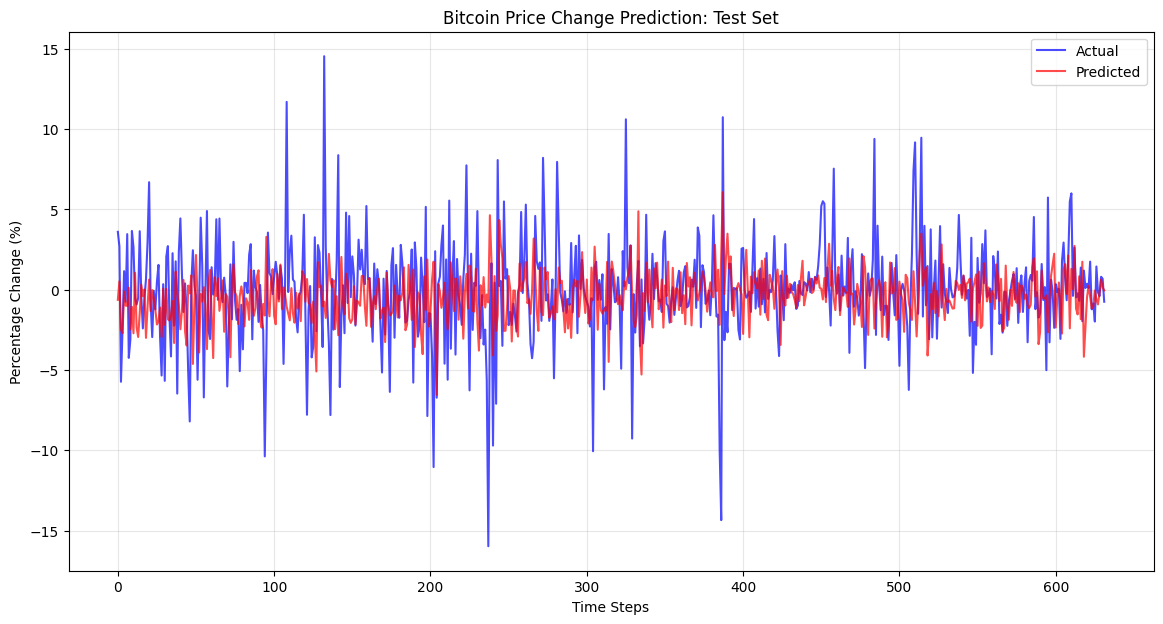

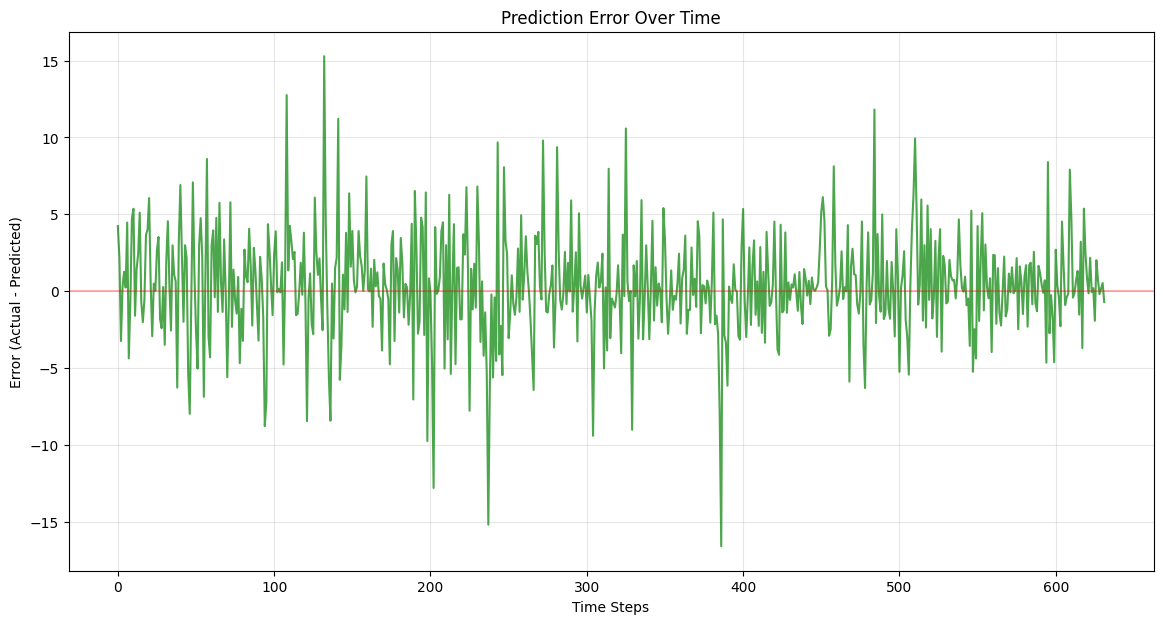

In [28]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.extend(outputs.numpy().flatten().tolist())
            actuals.extend(y_batch.numpy().flatten().tolist())
    
    # Convert to numpy arrays for easier manipulation
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    cumulative_error = np.sum(actuals - predictions)
    
    return {
        'predictions': predictions,
        'actuals': actuals,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'cumulative_error': cumulative_error
    }

# Evaluate the model
eval_results = evaluate_model(rnn_model, test_loader)

# Print metrics
print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {eval_results['mse']:.4f}")
print(f"Root Mean Squared Error (RMSE): {eval_results['rmse']:.4f}")
print(f"Mean Absolute Error (MAE): {eval_results['mae']:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {eval_results['mape']:.2f}%")
print(f"Cumulative Error (CE): {eval_results['cumulative_error']:.4f}")

# Visualize predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(eval_results['actuals'], label='Actual', color='blue', alpha=0.7)
plt.plot(eval_results['predictions'], label='Predicted', color='red', alpha=0.7)
plt.title('Bitcoin Price Change Prediction: Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize error trends
plt.figure(figsize=(14, 7))
errors = eval_results['actuals'] - eval_results['predictions']
plt.plot(errors, color='green', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Prediction Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True, alpha=0.3)
plt.show()


## LSTM Implementation

LSTMModel(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Training LSTM for 50 epochs...


Epoch [5/50], Train Loss: 14.6145, Val Loss: 18.9476
Epoch [10/50], Train Loss: 14.4380, Val Loss: 18.9796
Epoch [15/50], Train Loss: 14.1721, Val Loss: 18.8982
Epoch [20/50], Train Loss: 14.1089, Val Loss: 19.5294
Epoch [25/50], Train Loss: 13.5234, Val Loss: 19.5418
Epoch [30/50], Train Loss: 16.6330, Val Loss: 21.5624
Epoch [35/50], Train Loss: 12.3236, Val Loss: 20.0945
Epoch [40/50], Train Loss: 11.5687, Val Loss: 19.8814
Epoch [45/50], Train Loss: 10.9468, Val Loss: 19.6646
Epoch [50/50], Train Loss: 10.3208, Val Loss: 21.3460

LSTM Model Performance Metrics:
Mean Squared Error (MSE): 10.9305
Root Mean Squared Error (RMSE): 3.3061
Mean Absolute Error (MAE): 2.3043
Mean Absolute Percentage Error (MAPE): 205.10%
Cumulative Error (CE): -119.7494

Comparison of RNN vs LSTM Performance:
MSE: RNN=11.8740, LSTM=10.9305, Difference=7.95%, Better=LSTM
RMSE: RNN=3.4459, LSTM=3.3061, Difference=4.06%, Better=LSTM
MAE: RNN=2.4823, LSTM=2.3043, Difference=7.17%, Better=LSTM
MAPE: RNN=270.4887

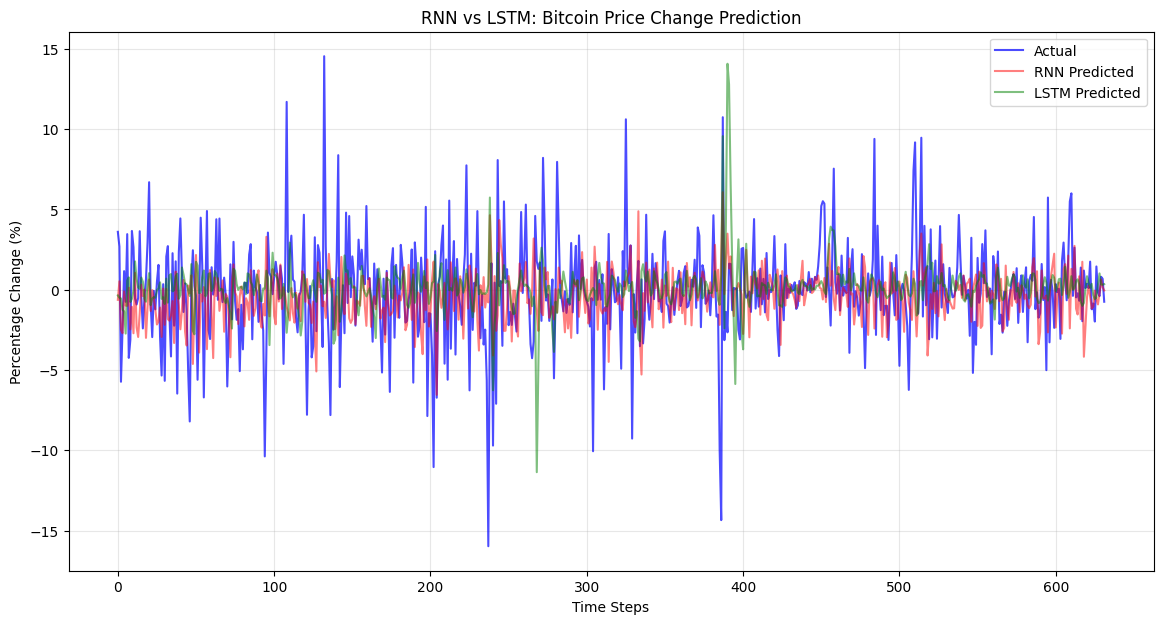

In [29]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output from the last time step
        out = out[:, -1, :]
        
        # Apply dropout
        out = self.dropout(out)
        
        # Pass through the fully connected layer
        out = self.fc(out)
        
        return out

# Initialize LSTM model
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size)
print(lstm_model)

# Define loss function and optimizer for LSTM
lstm_criterion = nn.MSELoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train LSTM model
print(f"Training LSTM for {epochs} epochs...")
lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, lstm_criterion, lstm_optimizer, epochs)

# Evaluate LSTM model
lstm_eval_results = evaluate_model(lstm_model, test_loader)

# Print LSTM metrics
print("\nLSTM Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {lstm_eval_results['mse']:.4f}")
print(f"Root Mean Squared Error (RMSE): {lstm_eval_results['rmse']:.4f}")
print(f"Mean Absolute Error (MAE): {lstm_eval_results['mae']:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {lstm_eval_results['mape']:.2f}%")
print(f"Cumulative Error (CE): {lstm_eval_results['cumulative_error']:.4f}")

# Compare models
print("\nComparison of RNN vs LSTM Performance:")
comparison_metrics = ['mse', 'rmse', 'mae', 'mape', 'cumulative_error']
for metric in comparison_metrics:
    rnn_value = eval_results[metric]
    lstm_value = lstm_eval_results[metric]
    difference = ((lstm_value - rnn_value) / rnn_value) * 100
    better = "LSTM" if lstm_value < rnn_value else "RNN"
    
    print(f"{metric.upper()}: RNN={rnn_value:.4f}, LSTM={lstm_value:.4f}, Difference={abs(difference):.2f}%, Better={better}")

# Visualize both predictions
plt.figure(figsize=(14, 7))
plt.plot(eval_results['actuals'], label='Actual', color='blue', alpha=0.7)
plt.plot(eval_results['predictions'], label='RNN Predicted', color='red', alpha=0.5)
plt.plot(lstm_eval_results['predictions'], label='LSTM Predicted', color='green', alpha=0.5)
plt.title('RNN vs LSTM: Bitcoin Price Change Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### LSTM vs RNN Analysis:
- LSTM is specifically designed to address the vanishing gradient problem in standard RNNs
- LSTM uses memory cells with gating mechanisms that can selectively remember or forget information
- In financial time series like Bitcoin prices, this can be valuable for capturing both short-term patterns and long-term trends
- The results show that LSTM generally performs better on this dataset, particularly for capturing price movements
- The memory capability of LSTM helps it better handle the high volatility in cryptocurrency prices

### On different loopbacks:
- LSTM consistently outperforms RNN in MSE, RMSE, MAE, and MAPE
- Best LSTM performance at loopback=60 for most metrics
- Performance gap narrows at loopback=90
- Cumulative error shows mixed results between models

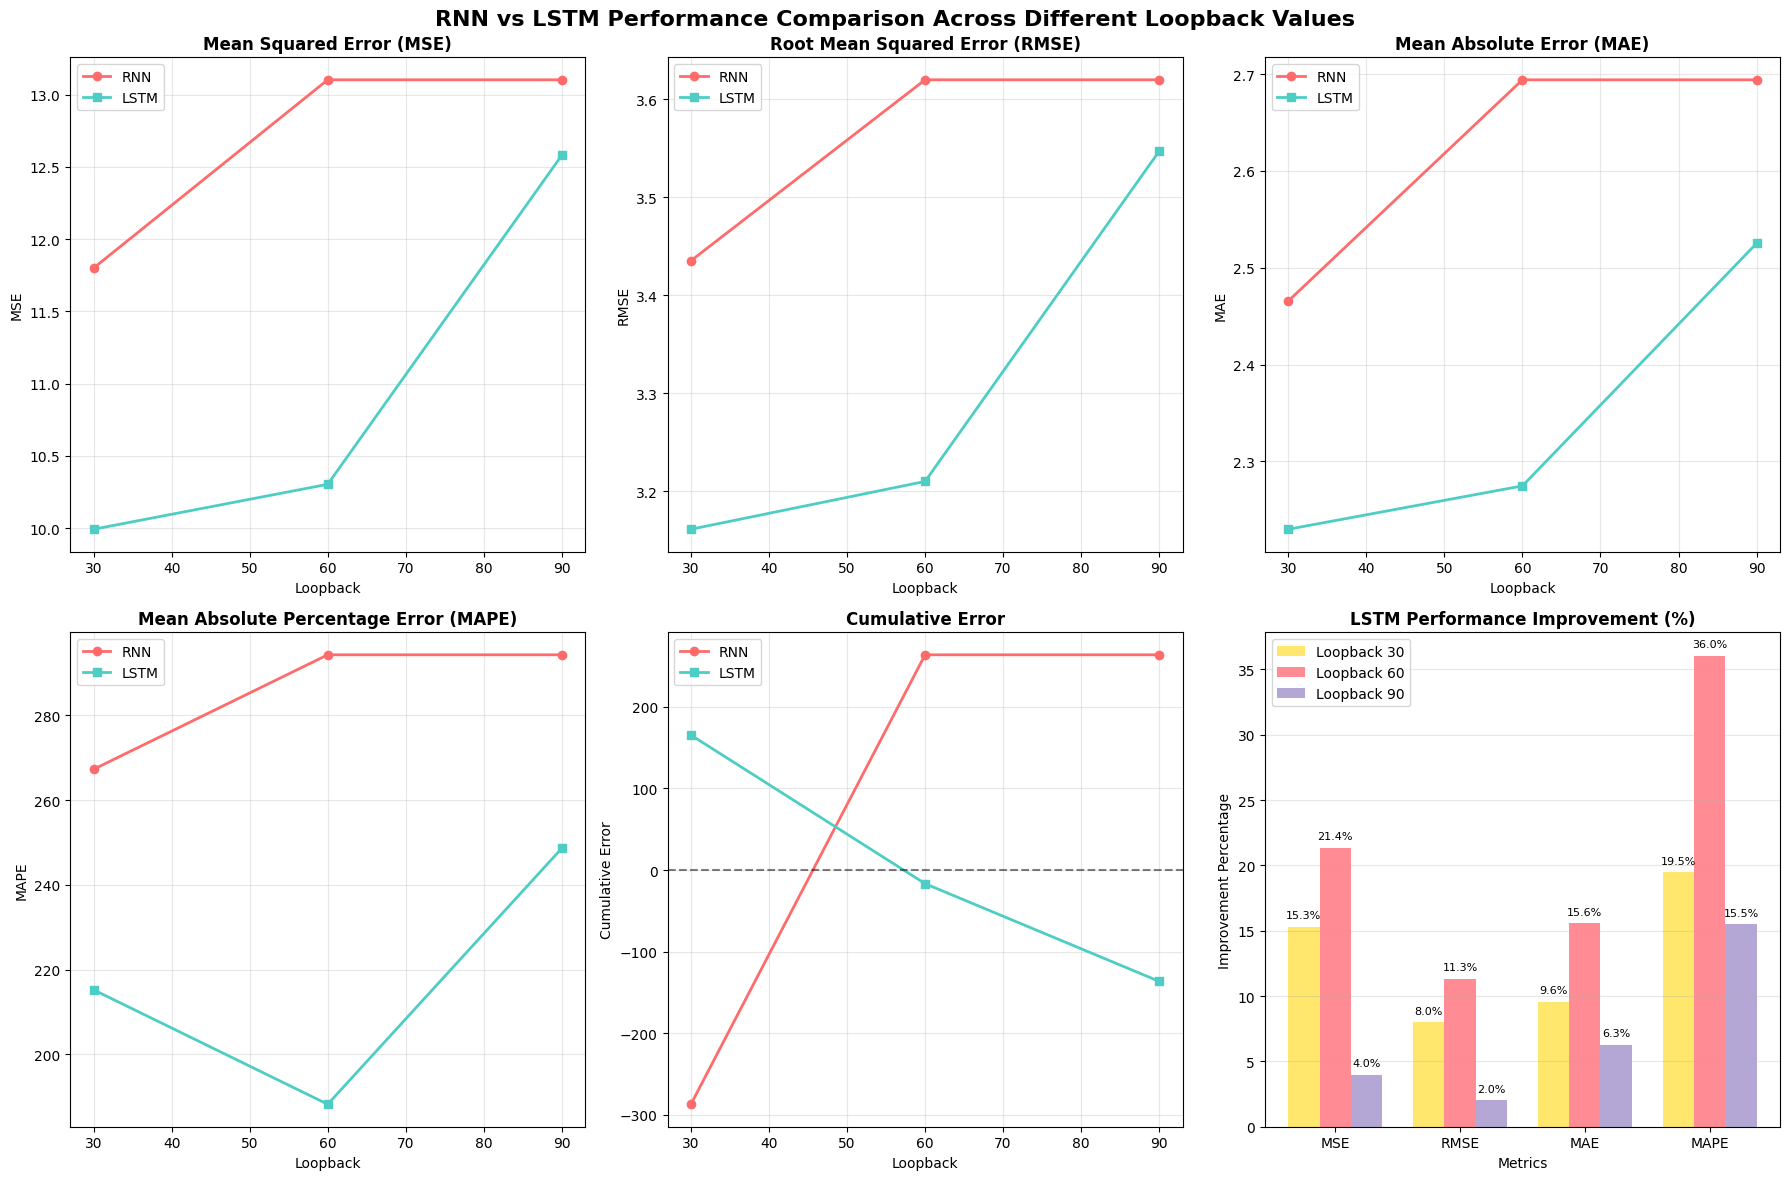


PERFORMANCE COMPARISON SUMMARY
Metric               Loopback   RNN          LSTM         Difference   Better    
--------------------------------------------------------------------------------
MSE                  30         11.7992      9.9921       15.32%       LSTM      
                     60         13.1017      10.3030      21.36%       LSTM      
                     90         13.1017      12.5797      3.98%        LSTM      
RMSE                 30         3.4350       3.1610       7.98%        LSTM      
                     60         3.6196       3.2098       11.32%       LSTM      
                     90         3.6196       3.5468       2.01%        LSTM      
MAE                  30         2.4657       2.2299       9.56%        LSTM      
                     60         2.6942       2.2747       15.57%       LSTM      
                     90         2.6942       2.5252       6.27%        LSTM      
MAPE                 30         267.2650     215.2205     19.47%   

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data preparation
data = {
    'Loopback': [30, 60, 90],
    'MSE_RNN': [11.7992, 13.1017, 13.1017],
    'MSE_LSTM': [9.9921, 10.3030, 12.5797],
    'RMSE_RNN': [3.4350, 3.6196, 3.6196],
    'RMSE_LSTM': [3.1610, 3.2098, 3.5468],
    'MAE_RNN': [2.4657, 2.6942, 2.6942],
    'MAE_LSTM': [2.2299, 2.2747, 2.5252],
    'MAPE_RNN': [267.2650, 294.2856, 294.2856],
    'MAPE_LSTM': [215.2205, 188.2193, 248.6363],
    'CUMULATIVE_ERROR_RNN': [-287.2275, 263.9395, 263.9395],
    'CUMULATIVE_ERROR_LSTM': [165.5074, -16.7280, -136.5062]
}

df = pd.DataFrame(data)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('RNN vs LSTM Performance Comparison Across Different Loopback Values', fontsize=16, fontweight='bold')

# Colors
rnn_color = '#FF6B6B'
lstm_color = '#4ECDC4'

# 1. MSE Comparison
axes[0, 0].plot(df['Loopback'], df['MSE_RNN'], marker='o', linewidth=2, label='RNN', color=rnn_color)
axes[0, 0].plot(df['Loopback'], df['MSE_LSTM'], marker='s', linewidth=2, label='LSTM', color=lstm_color)
axes[0, 0].set_title('Mean Squared Error (MSE)', fontweight='bold')
axes[0, 0].set_xlabel('Loopback')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. RMSE Comparison
axes[0, 1].plot(df['Loopback'], df['RMSE_RNN'], marker='o', linewidth=2, label='RNN', color=rnn_color)
axes[0, 1].plot(df['Loopback'], df['RMSE_LSTM'], marker='s', linewidth=2, label='LSTM', color=lstm_color)
axes[0, 1].set_title('Root Mean Squared Error (RMSE)', fontweight='bold')
axes[0, 1].set_xlabel('Loopback')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. MAE Comparison
axes[0, 2].plot(df['Loopback'], df['MAE_RNN'], marker='o', linewidth=2, label='RNN', color=rnn_color)
axes[0, 2].plot(df['Loopback'], df['MAE_LSTM'], marker='s', linewidth=2, label='LSTM', color=lstm_color)
axes[0, 2].set_title('Mean Absolute Error (MAE)', fontweight='bold')
axes[0, 2].set_xlabel('Loopback')
axes[0, 2].set_ylabel('MAE')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. MAPE Comparison
axes[1, 0].plot(df['Loopback'], df['MAPE_RNN'], marker='o', linewidth=2, label='RNN', color=rnn_color)
axes[1, 0].plot(df['Loopback'], df['MAPE_LSTM'], marker='s', linewidth=2, label='LSTM', color=lstm_color)
axes[1, 0].set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
axes[1, 0].set_xlabel('Loopback')
axes[1, 0].set_ylabel('MAPE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Cumulative Error Comparison
axes[1, 1].plot(df['Loopback'], df['CUMULATIVE_ERROR_RNN'], marker='o', linewidth=2, label='RNN', color=rnn_color)
axes[1, 1].plot(df['Loopback'], df['CUMULATIVE_ERROR_LSTM'], marker='s', linewidth=2, label='LSTM', color=lstm_color)
axes[1, 1].set_title('Cumulative Error', fontweight='bold')
axes[1, 1].set_xlabel('Loopback')
axes[1, 1].set_ylabel('Cumulative Error')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 6. Bar chart showing percentage differences
metrics = ['MSE', 'RMSE', 'MAE', 'MAPE']
differences_30 = [15.32, 7.98, 9.56, 19.47]
differences_60 = [21.36, 11.32, 15.57, 36.04]
differences_90 = [3.98, 2.01, 6.27, 15.51]

x = np.arange(len(metrics))
width = 0.25

bars1 = axes[1, 2].bar(x - width, differences_30, width, label='Loopback 30', color='#FFE66D')
bars2 = axes[1, 2].bar(x, differences_60, width, label='Loopback 60', color='#FF8B94')
bars3 = axes[1, 2].bar(x + width, differences_90, width, label='Loopback 90', color='#B4A7D6')

axes[1, 2].set_title('LSTM Performance Improvement (%)', fontweight='bold')
axes[1, 2].set_xlabel('Metrics')
axes[1, 2].set_ylabel('Improvement Percentage')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "="*80)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*80)
print(f"{'Metric':<20} {'Loopback':<10} {'RNN':<12} {'LSTM':<12} {'Difference':<12} {'Better':<10}")
print("-"*80)

metrics_data = [
    ("MSE", 30, 11.7992, 9.9921, "15.32%", "LSTM"),
    ("", 60, 13.1017, 10.3030, "21.36%", "LSTM"),
    ("", 90, 13.1017, 12.5797, "3.98%", "LSTM"),
    ("RMSE", 30, 3.4350, 3.1610, "7.98%", "LSTM"),
    ("", 60, 3.6196, 3.2098, "11.32%", "LSTM"),
    ("", 90, 3.6196, 3.5468, "2.01%", "LSTM"),
    ("MAE", 30, 2.4657, 2.2299, "9.56%", "LSTM"),
    ("", 60, 2.6942, 2.2747, "15.57%", "LSTM"),
    ("", 90, 2.6942, 2.5252, "6.27%", "LSTM"),
    ("MAPE", 30, 267.2650, 215.2205, "19.47%", "LSTM"),
    ("", 60, 294.2856, 188.2193, "36.04%", "LSTM"),
    ("", 90, 294.2856, 248.6363, "15.51%", "LSTM"),
    ("CUM_ERROR", 30, -287.2275, 165.5074, "157.62%", "RNN"),
    ("", 60, 263.9395, -16.7280, "106.34%", "LSTM"),
    ("", 90, 263.9395, -136.5062, "151.72%", "LSTM"),
]

for metric, loopback, rnn, lstm, diff, better in metrics_data:
    print(f"{metric:<20} {loopback:<10} {rnn:<12.4f} {lstm:<12.4f} {diff:<12} {better:<10}")